In [52]:
import numpy as np
from matplotlib import pyplot as plt
import h5py

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications.inception_v3 import preprocess_input

from lime import lime_image

In [53]:
import h5py as hd
pannuke= hd.File('/mnt/nas2/results/IntermediateResults/Camelyon/pannuke/patches_fix.hdf5', 'r', libver='latest', swmr=True)
filename = "../input/pannukeall/all_tumor_pannuke.hdf5"
f = pannuke

f['pannuke/fold1/75/tumor'].keys()
im = f['pannuke/fold1/75/tumor/center/patch'][0]
mask = f['pannuke/fold1/75/tumor/center/mask'][0]

In [61]:
model = tf.keras.models.load_model('/mnt/nas2/results/IntermediateResults/Mara/MELBA/baseline_def_1/best_model.h5', compile=False)
model.layers[-1].activation = tf.keras.activations.sigmoid
model.compile()

In [62]:
#We don't directly use the base model because we want to be sure we are perturbing the images before preprocessing them.
#Otherwise covering the superpixels in 0 might not mean covering them in black.
#Best way to control this is to just define a wrapper-like class around the model, that includes the preprocessing in it.
#I'm also converting the sigmoid output to softmax-like because that's generally easier to handle and debug in LIME.
#GradCAM doesn't care about any of this so we can just use the model directly.

class MyModel():
    def __init__(self,model):
        self.model = model
        self.input_shape = model.input_shape
        self.output_shape = model.output_shape
        
    def predict(self, batch_images):
        
        #Image must be preprocessed before passed to LIME.
        batch_images = preprocess_input(batch_images.copy()) 
        
        sigm = self.model.predict(batch_images)
        
        softm = np.hstack((1-sigm,sigm))
        
        return softm


model_with_preprocessing = MyModel(model)

In [63]:
#Renumber segments, because they are numbered arbitrarily in the mask files.
segments = mask[:,:,0].copy()
for i, num in enumerate(np.unique(mask[:,:,0])):
    
    segments[segments==num]=i

#LIME is expecting a segmentation function, so we define one just to pass the segments above as superpixels.
def segfunc(im):
    return segments

In [64]:
#Generate Squares
from skimage.segmentation import mark_boundaries
squares = np.zeros(im.shape[:2])
counter = 0
for hor in range(3):
    for ver in range(3):
        squares[75*hor:75*(hor+1),75*ver:75*(ver+1)]=counter
        counter+=1

#Renumber segments, because they are numbered arbitrarily in the mask files.
segments = np.sum(mask[:,:,0:5],axis=2).copy()

temp_renumber = [8+item for item in list(range(len(np.unique(segments))))]

renumbering_map = dict(zip(np.unique(segments),temp_renumber))

segments = np.vectorize(renumbering_map.get)(segments)
segments = np.where(segments.copy()==8,squares,segments)

#LIME is expecting a segmentation function, so we define one just to pass the segments above as superpixels.
def segfunc(im):
    return segments

#Mark the nuclei
mark_colors = [[1,0,0],[0,1,0],[0,0,1],[1,1,0],[1,0,1]]
mark = im.copy()/255

In [65]:
#Generate LIME explanation for class 1
explainer = lime_image.LimeImageExplainer()
class_idx=1
explanation_genetic = explainer.explain_instance(im.copy(), 
                                                 model_with_preprocessing.predict, 
                                                 segmentation_fn = segfunc, 
                                                 top_labels=3,#Just making sure we generate explanations for both classes. Any number >2 should work. 
                                                 hide_color=0,#Cover superpixels in black. 
                                                 num_samples=200,
                                                 progress_bar=False)
dict_genetic = dict(explanation_genetic.local_exp[class_idx])
orig_heatmap = np.vectorize(dict_genetic.get)(explanation_genetic.segments)

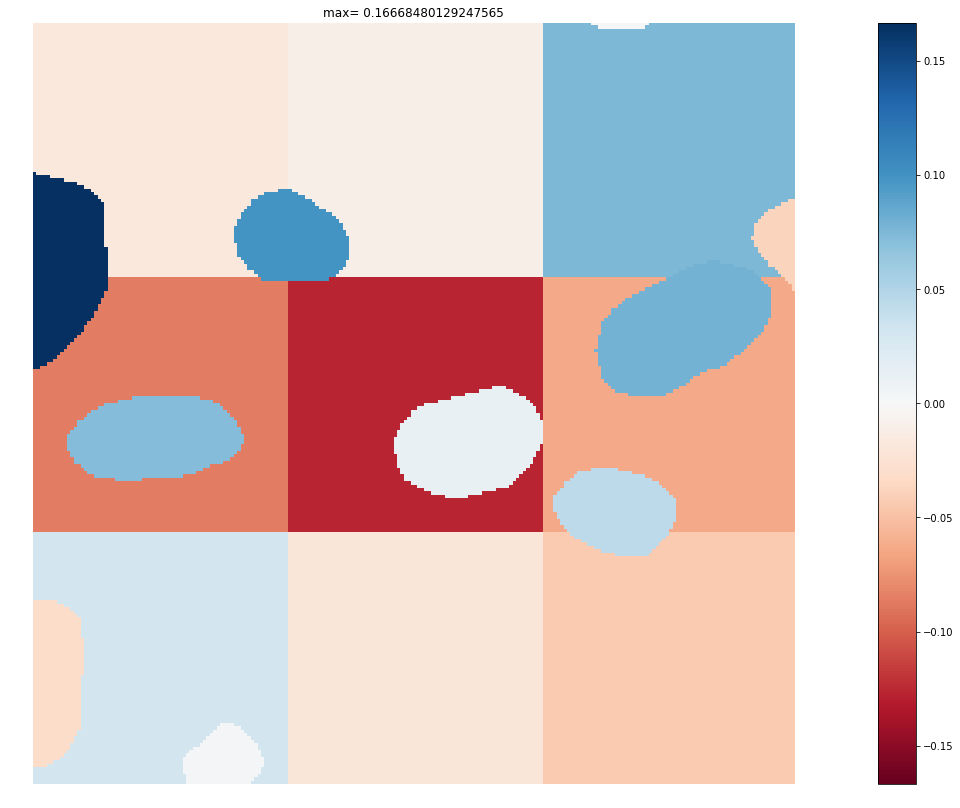

(-0.5, 223.5, 223.5, -0.5)

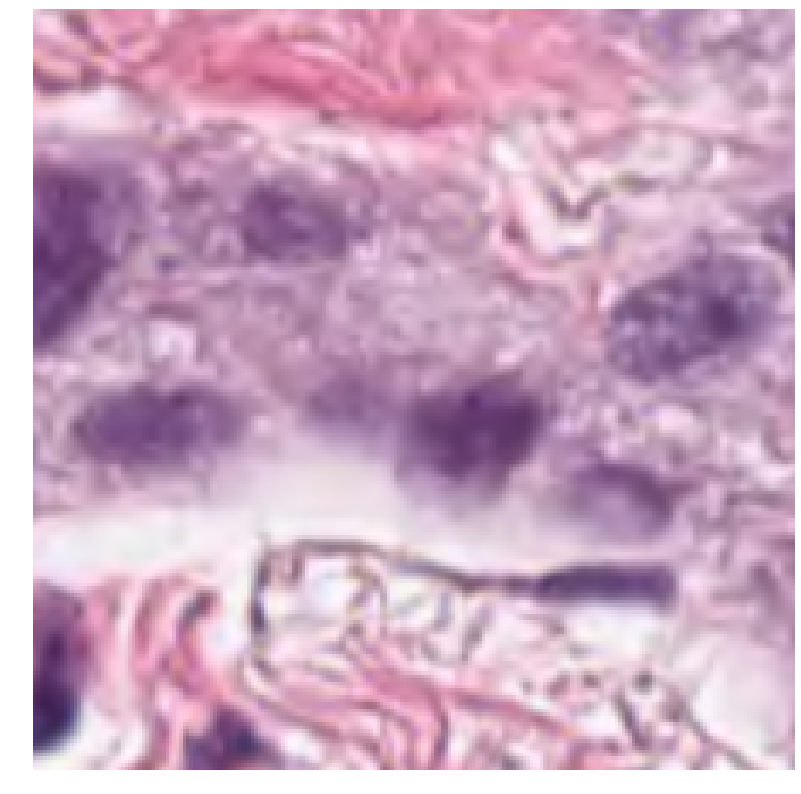

In [59]:
#Plot heatmap
plt.figure(facecolor='white')
plt.imshow(heatmap, cmap = 'RdBu', vmin=-heatmap.max(), vmax = heatmap.max())
plt.title('max= {}'.format(heatmap.max()))
plt.colorbar()
plt.axis('off')
plt.show()
plt.figure(facecolor='white')
plt.imshow(im/255)
plt.axis('off')

In [41]:
explainer = lime_image.LimeImageExplainer()
class_idx=1
expl={}
for layer in model_with_preprocessing.model.layers:
    #print('Reset weights of {}'.format(layer.name))
    #layer.build(layer.input_shape)
    dim=layer.get_weights()
    if len(dim)>1:
        weights = [np.random.random(dim[i].shape) for i in range(len(dim))]
        #dim=dim[0].shape
        layer.set_weights(weights)
    if layer.name in ['predictions','mixed10','mixed9','mixed8','mixed7', 'mixed6',  'mixed5', 'mixed4', 'mixed3', 'mixed2','mixed1', 'mixed0']:
        print(layer.name)
        #Generate LIME explanation for class 1

        explanation_genetic = explainer.explain_instance(im.copy(), 
                                                         model_with_preprocessing.predict, 
                                                         segmentation_fn = segfunc, 
                                                         top_labels=3,#Just making sure we generate explanations for both classes. Any number >2 should work. 
                                                         hide_color=0,#Cover superpixels in black. 
                                                         num_samples=200,
                                                         progress_bar=False)
        dict_genetic = dict(explanation_genetic.local_exp[class_idx])
        heatmap = np.vectorize(dict_genetic.get)(explanation_genetic.segments)
        expl[layer.name]=heatmap

mixed0
mixed1
mixed2
mixed3
mixed4
mixed5
mixed6
mixed7
mixed8
mixed9
mixed10
predictions


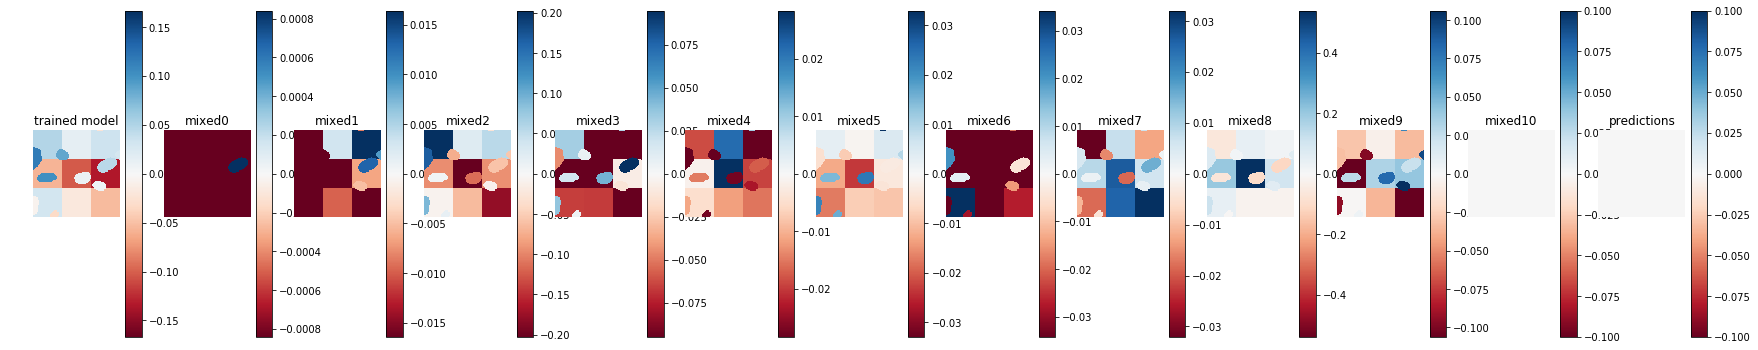

In [66]:
plt.rcParams['figure.figsize']=(30,14)
#Plot heatmap
#plt.figure(facecolor='white')
plt.subplot(1,13,1)
plt.imshow(orig_heatmap, cmap = 'RdBu', vmin=-heatmap.max(), vmax = heatmap.max())
plt.title('trained model')
plt.colorbar()
plt.axis('off')
c=2
for l in ["mixed0",
"mixed1",
"mixed2",
"mixed3",
"mixed4",
"mixed5",
"mixed6",
"mixed7",
"mixed8",
"mixed9",
"mixed10",
"predictions"]:
    plt.subplot(1,13,c)
    #plt.figure()
    #plt.imshow(expl[l])
    #Plot heatmap
    #plt.figure(facecolor='white')
    heatmap=expl[l]
    plt.imshow(heatmap, cmap = 'RdBu', vmin=-heatmap.max(), vmax = heatmap.max())
    plt.title(l)
    #plt.title('max= {}'.format(heatmap.max()))
    plt.colorbar()
    plt.axis('off')
    #plt.show()
    c+=1
    
    #plt.title(l)